## Описание проекта
Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.  
Шаги для выбора локации обычно такие:  
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

### Условия задачи:  
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).  
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  
- Бюджет на разработку скважин в регионе — 10 млрд рублей.  
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.  
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.  

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Описание данных
Данные геологоразведки трёх регионов находятся в файлах: 
- **`geo_data_0.csv`**, 
- **`geo_data_1.csv`**, 
- **`geo_data_2.csv`**.  

Столбцы:
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);  
- `product` — объём запасов в скважине (тыс. баррелей).  

#### Содержание:  
1. Получение и предобработка данных
2. Обучение модели
3. Расчет прибыли и оценка рисков
4. Выводы

---
## Выполнение проекта

### 1. Получение и предобработка данных

Импортируем необходимые библиотеки и модули для работы.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Получим данные, и ознакомимся с ними. проверим типы данных, наличие пропусков и дубликатов.

In [2]:
def get_data(path):
    df = pd.read_csv(path)
    display(df)
    print()
    print(df.info())
    print()
    print('Дубликатов в данных =', df.duplicated().sum())
    return df

In [3]:
geo_data_0 = get_data('/datasets/geo_data_0.csv')

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Дубликатов в данных = 0


In [4]:
geo_data_1 = get_data('/datasets/geo_data_1.csv')

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Дубликатов в данных = 0


In [5]:
geo_data_2 = get_data('/datasets/geo_data_2.csv')

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Дубликатов в данных = 0


Пропусков и дубликатов нет, типы данных корректны

Проверим корреляцию признаков

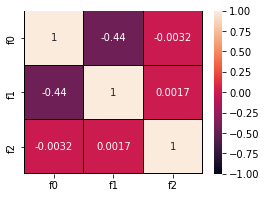

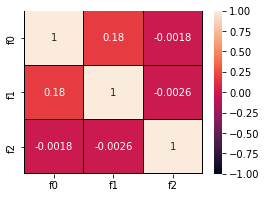

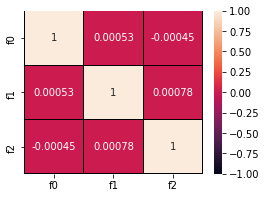

In [6]:
for df in [geo_data_0, geo_data_1, geo_data_2]:
    plt.figure(figsize=(4, 3))
    sns.heatmap(df.drop(columns=['id', 'product']).corr(), 
                        annot=True, vmax=1, vmin=-1, 
                        linewidths=0.1, linecolor='black')
    plt.show()

Выраженной корреляции нет ни в одном из регионов

### 2. Обучение модели

Напишем функцию для обучения модели линейной регрессии, и расчета основных метрик и значений

In [7]:
def model_work(df):
    
    features = df.drop(columns=['id', 'product'])
    target = df['product']
    scaler = StandardScaler()
    feature_train, feature_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=123)
    feature_train = scaler.fit_transform(feature_train)
    feature_valid = scaler.transform(feature_valid)
    print('Размер тренировочной выборки:', feature_train.shape)
    print('Размер валидационной выборки:', feature_valid.shape)
    model = LinearRegression()
    model.fit(feature_train, target_train)
    predict = pd.Series(model.predict(feature_valid), index=target_valid.index)
    predict.name = 'predict'
    target_valid.name = 'target'
    print('Среднее прогнозное значение: {:.2f}'.format(predict.mean()))
    print('RMSE: {:.2f}'.format(mean_squared_error(y_true=target_valid, y_pred=predict) ** 0.5))
    new_df = predict.reset_index().merge(target_valid.reset_index(), on='index').set_index('index')
    new_df.index.name = None
    
    return new_df

Применим функцию к данным по каждому региону и сохраним значения

In [8]:
data_geo_0 = model_work(geo_data_0)

Размер тренировочной выборки: (75000, 3)
Размер валидационной выборки: (25000, 3)
Среднее прогнозное значение: 92.55
RMSE: 37.65


In [9]:
data_geo_1 = model_work(geo_data_1)

Размер тренировочной выборки: (75000, 3)
Размер валидационной выборки: (25000, 3)
Среднее прогнозное значение: 69.28
RMSE: 0.90


In [10]:
data_geo_2 = model_work(geo_data_2)

Размер тренировочной выборки: (75000, 3)
Размер валидационной выборки: (25000, 3)
Среднее прогнозное значение: 95.10
RMSE: 40.13


Наиболее точно модель отработала на данных о втором регионе, но при этом средний прогноз значений в нем существенно ниже, в первом и третьем регионах средняя ошибка слишком велика

Сохраним в переменные установленные показатели для расчета - бюджет на разработку региона, количество скважин, которое будет разрабатываться, прибыль от продажи 1 тыс баррелей нефти

In [11]:
budget_on_reg = 10000000000
sks = 200
price_1_sk = budget_on_reg / sks
one_thousand_barrel_income = 450000

In [12]:
print('Объем скважины, необходимый для безубыточности = {:.2f}'.format(price_1_sk / one_thousand_barrel_income))

Объем скважины, необходимый для безубыточности = 111.11


Получается, что первый и третий регион потенциально обладают скважинами более близкими к безубыточной добыче, хотя ошибка такого прогноза тоже весьма существенна

### 3. Расчет прибыли и оценка рисков

Напишем функцию для расчета прибыли в случае разработки двухсот месторождений с самыми большими прогнозируемыми запасами

In [13]:
def profit_calc(df):
    top_pred = df.sort_values('predict', ascending=False).head(sks)
    total_oil = top_pred['target'].sum() 
    income = round(total_oil * one_thousand_barrel_income)
    profit = income - budget_on_reg
    return profit

Так же напишем функцию для проведения бутстрепа. Создаём 1000 подвыборок из 500 рандомных скважин каждая, с помощью предыдущей функции считаем прибыль от разработки 200 самых многообещающих скважин в ней, после чего определим границы 95% доверительного интервала этих значений, а так же оценим вероятность получить убыток

In [23]:
def stat_calc(df):

    state = np.random.RandomState(123)
    values = []

    for i in range(1000):

        subsample = df.sample(n=500, replace=True, random_state=state)
        profit = profit_calc(subsample)
        values.append(profit)

    values = pd.Series(values)

    mean_profit = round(values.mean())
    lower = round(values.quantile(q=0.025))
    upper = round(values.quantile(q=0.975))

    loss_risk = sum(values < 0) / values.shape[0]

    return [mean_profit, lower, upper, loss_risk]

In [15]:
def print_result(df):
    stats_geo = stat_calc(df)
    print('Средняя прибыль = {0:,}'.format(stats_geo[0]))
    print('Доверительный интервал 95%  {0:,} - {1:,}'.format(stats_geo[1], stats_geo[2]))
    print('Риск убытков = {:.1%}'.format(stats_geo[3]))

Теперь применим функции на данных каждого региона

In [24]:
print_result(data_geo_0)

Средняя прибыль = 477,416,824
Доверительный интервал 95%  -57,993,912 - 974,822,015
Риск убытков = 4.1%


In [25]:
print_result(data_geo_1)

Средняя прибыль = 479,190,161
Доверительный интервал 95%  58,726,877 - 874,424,820
Риск убытков = 0.9%


In [26]:
print_result(data_geo_2)

Средняя прибыль = 343,454,377
Доверительный интервал 95%  -231,376,255 - 860,840,670
Риск убытков = 9.9%


### 4. Вывод

Получилось, что наиболее выгодной является добыча во втором регионе, т.к. только там риск убытков менее 2.5%, и 95% доверительный интервал находится в границах положительных чисел (прибыли).